Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Iga Miller"

---

# 3. Grupowo ekwiwariantne sieci konwolucyjne
Ostatnią architekturą, którą dzisiaj sprawdzimy są tzw. *Group Equivariant Neural Networks*, czyli sieci neuronowe (w naszym przypadku konwolucyjne), które opisują funkcje ekwiwariantne względem określonej grupy symetrii. Po raz pierwszy koncepcja takich sieci została opisana w 2016 r. przez Cohena i Wellinga w pracy [Group Equivariant Convolutional Networks](https://arxiv.org/pdf/1602.07576.pdf). W pracy formalizują zastosowanie grup symetrii do modelowania struktury danych – dokładniej mówiąc rozważają dwie grupy: *p4* (obroty o 90 stopni) oraz *p4m* (obroty o 90 stopni i odbicia). 


Implementacja grupowo ekwiwariantnych sieci jest zadaniem nietrywialnym i czasochłonnym, stąd w tym zeszycie wykorzystamy bibliotekę `e2cnn`, która posiada zaimplementowane warstwy grupowo ekwiwariantne.

In [2]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

## 3.1. Architektura
Założeniem modelu będzie, aby koder był w stanie stworzyć niezmienniczą (ang. *invariant*) reprezentację podstawowych i obróconych obrazów wejściowych. Moduł dekodera nie będziemy modyfikować i użyjemy klasy `CNNDecoder` z poprzedniego zeszytu. 

## Zadanie 3.1. (4 pkt)
W celu zrozumienia grupowo ekwiwariantnych sieci zaleca się zapoznanie z poniższymi materiałami:
- [2-częściowy blog na temat G-CNN](https://fabianfuchsml.github.io/equivariance1of2/)
- [Wykład Erika Bekkersa "Group Equivariant Deep Learning (UvA - 2022)" (Lecture 1.1-1.7)](https://youtube.com/playlist?list=PL8FnQMH2k7jzPrxqdYufoiYVHim8PyZWd)

Zapoznaj się z biblioteką E2CNN:
- [Przykład użycia](https://github.com/QUVA-Lab/e2cnn#getting-started)
- [Zeszyt wprowadzający](https://github.com/QUVA-Lab/e2cnn/blob/master/examples/introduction.ipynb)

i zaimplementuj moduł kodera z następującą architekturą:
- dla każdej warstwy konwolucji przymij takie same parametry jak dla `CNNEncoder` z poprzedniego zeszytu, tzn. `kernel_size=3`, `stride=2`, `padding=1`
- pierwsza warstwa konwolucji obrotowej `R2Conv` obliczająca 8 filtrów wyjściowych
- aktywacja ReLU
- druga warstwa konwolucji obrotowej `R2Conv` obliczająca 16 filtrów wyjściowych
- aktywacja ReLU
- trzecia warstwa konwolucji obrotowej `R2Conv` obliczająca 32 filtry wyjściowe
- redukacja maksymalizująca (`PointwiseMaxPoolAntialiased`) z kernelem o wymiarze `3`
- redukcja grupowa (`GroupPooling`)
- część wielowarstwowego perceptrona z modelu `CNNEncoder`, tzn.:
    - spłaszczenie macierzy do wektora, 
    - warstwa liniowa z 128 cechami wyjściowymi
    - aktywacja ReLU
    - warstwa liniowa z `latent_dim` cechami wyjściowymi

Jako grupę symetrii przyjmij grupę obrotów dyskretnych, tzw. grupę cykliczną $C_N$ (`Rot2dOnR2`).

Pamiętaj użyciu właściwych modułów z pakietu `e2cnn.nn` oraz `torch.nn`.

In [3]:
from e2cnn import gspaces
from e2cnn import nn as enn
from torch import nn
import torch


class GCNNEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim: int, N: int):
        super().__init__()
        self.r2_act = gspaces.Rot2dOnR2(N=N)

        in_type = enn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        self.input_type = in_type

        out_type = enn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr])
        self.block1 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            enn.ReLU(out_type, inplace=True)
        )
        in_type = self.block1.out_type
        out_type = enn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr])
        self.block2 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            enn.ReLU(out_type, inplace=True)
        )
        in_type = self.block2.out_type
        out_type = enn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr])
        self.block3 = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
        )
        self.pool = enn.PointwiseMaxPoolAntialiased(out_type, kernel_size=3)
        self.gpool = enn.GroupPooling(out_type)
        in_dim = self.gpool.out_type.size
        
        self._layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim),
        )

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        x = enn.GeometricTensor(img, self.input_type)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = self.gpool(x)
        x = x.tensor
        x = self._layers(x)

        return x


## 3.2. Uczenie modelu
W przeciwieństwie do poprzednich zeszytów, nie załączono wcześniej przygotowanego modelu, a uczenie należy przeprowadzić samemu. Uczenie powinno zająć kilkanaście/kilkadziesiąt minut, a w razie mocno ograniczonych zasobów należy skorzystać z Google Colab (aby wykorzystać GPU wystarczy przekazać odpowiedni parametr do `Trainer`, co jest opisane w dokumentacji: [Trainer API](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-class-api), [użycie GPU](https://lightning.ai/docs/pytorch/stable/accelerators/gpu_basic.html)).

In [4]:
LOG_PATH = "./data/GCNN/logs"
CHECKPOINT_PATH = "./data/GCNN/model.chkpt"

In [5]:
%load_ext tensorboard
%tensorboard --logdir $LOG_PATH --host 0.0.0.0 --port 6006

In [6]:
from src.dataset import SampledMNISTData
from src.ae import Autoencoder
from src.cnn import CNNDecoder

In [7]:
class GCNNAutoencoder(Autoencoder):
    
    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=GCNNEncoder(latent_dim=latent_dim, N=8),
            decoder=CNNDecoder(latent_dim=latent_dim),
        )


In [8]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from src.dataset import SampledMNISTData


if os.path.isfile(CHECKPOINT_PATH):
    # if already trained, load saved checkpoint
    # it is normal that some parameters are missing (difference is due to eval and train modes)
    gcnn_ae = GCNNAutoencoder.load_from_checkpoint(CHECKPOINT_PATH, strict=False, latent_dim=2)
else:
    # train model otherwise
    gcnn_ae = GCNNAutoencoder(latent_dim=2)
    trainer = Trainer(
        max_epochs=10,
        logger=TensorBoardLogger(save_dir=LOG_PATH, name="gcnn_ae", default_hp_metric=False),
        callbacks=[]
    )
    mnist = SampledMNISTData(num_samples_per_class=-1)

    trainer.fit(
        model=gcnn_ae,
        train_dataloaders=mnist,
    )

    trainer.save_checkpoint(filepath=CHECKPOINT_PATH)

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)
c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\pytorch_lightning\core\saving.py:158: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['_encoder.block1.0.expanded_bias', '_encoder.block1.0.filter', '_encoder.block2.0.expanded_bias', '_encoder.block2.0.filter', '_encoder.block3.0.expanded_bias', '_encoder.block3.0.filter']
  rank_zero_warn(


## 3.3. Badanie jakości reprezentacji w zadaniu

Wczytujemy losową próbkę zbioru danych MNIST:

In [9]:
mnist = SampledMNISTData(num_samples_per_class=100, seed=42)

Dla każdej próbki wyciągamy jej reprezentację (wektor dwu-wymiarowy) oraz etykietę:

In [10]:
from src.utils import extract_representations


representations = extract_representations(
    model=gcnn_ae,
    dataset=mnist,
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
from src.utils import evaluate_linear    


auc_train, auc_test = evaluate_linear(
    z_train=representations["train"]["z"],
    y_train=representations["train"]["y"],
    z_test=representations["test"]["z"],
    y_test=representations["test"]["y"],
)

print(f"AUC => train: {auc_train * 100.0:.2f} [%], test: {auc_test * 100.0:.2f} [%]")

AUC => train: 91.77 [%], test: 92.38 [%]


## 3.4. Wizualizacja przestrzeni reprezentacji

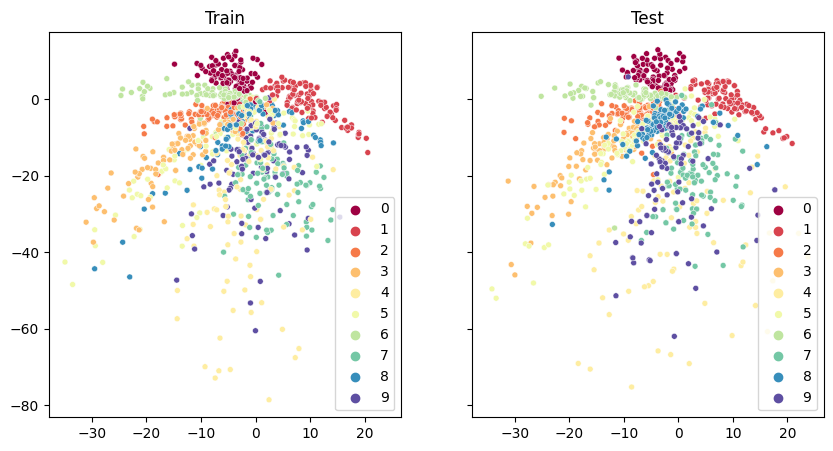

In [12]:
%matplotlib inline

from src.utils import visualize_latent_spaces


visualize_latent_spaces(representations)

## 3.5. Wizualizacja jakości rekonstrukcji

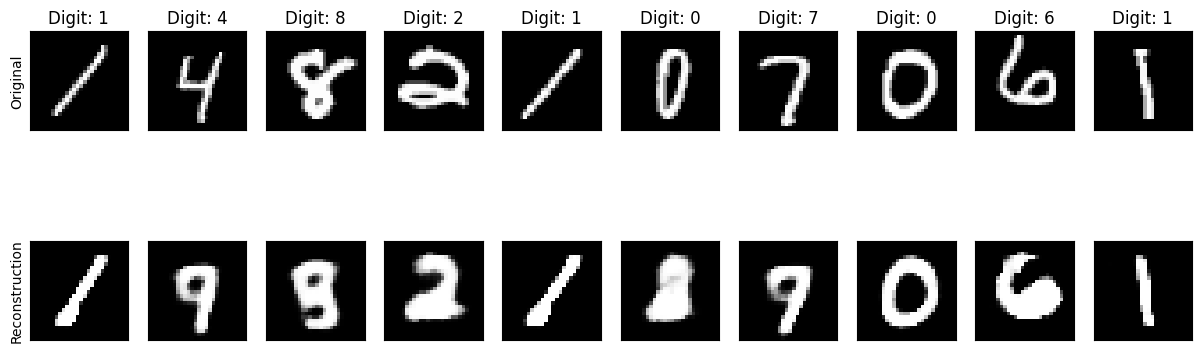

In [13]:
%matplotlib inline

from src.utils import visualize_random_sample

    
visualize_random_sample(model=gcnn_ae, dataset=mnist.mnist_train)

## 3.6. Odporność na obroty
Zbadamy jak się zachowuje model oparty o grupowo ekwiwariantne sieci konwolucyjne w przypadku obrotów.

Wybieramy dowolną instancję ze zbioru danych:

In [14]:
img, _ = mnist.mnist_train[256]

## Zadanie 3.3. (0 pkt)
Skopiuj implementację funkcji `rotate` z poprzedniego zeszytu.

In [15]:
import torch
import torchvision.transforms as transforms

def rotate(img: torch.Tensor, angle: float) -> torch.Tensor:
        
    rotated_img = transforms.functional.rotate(img.reshape(1, 28, 28), angle=angle, center=(img.shape[-1]//2, img.shape[-2]//2))
    rotated_img = rotated_img.squeeze(0)
    
    return rotated_img
    

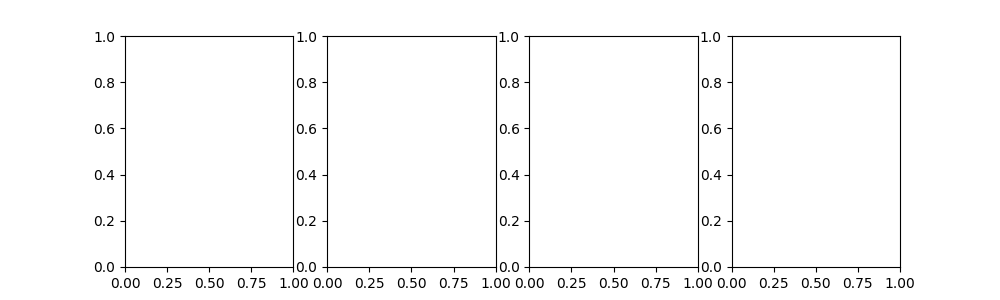

In [16]:
%matplotlib widget
from src.transforms import plot_transformation


plot_transformation(
    image=img,
    model=gcnn_ae,
    transformation_fn=rotate,
    min_param_value=0,
    max_param_value=360,
    step=45,
    keep_channel_dim=True,
)

## Zadanie 3.4 (1 pkt)
Czy autokoder G-CNN jest odporny na obroty obiektów? Z czego może to wynikać?

Autokoder G-CNN to typ CNN, który zawiera w swojej architekturze właściwości równoważników grup. Równoważność grupowa odnosi się do zdolności sieci do zachowania pewnych przekształceń lub symetrii w danych wejściowych. Wykorzystuje matematyczne właściwości grup, takie jak translacja, rotacja i odbicie, do konstruowania równoważnych filtrów splotowych. Filtry te zapewniają, że odpowiedzi sieci zmieniają się w przewidywalny sposób w ramach różnych transformacji. Wykorzystując właściwości ekwiwariantu grupowego, autokoder G-CNN może nauczyć się reprezentacji, które są bardziej odporne na rotację obiektów. 